In [2]:
import geopandas as gpd
import glob
from shapely.ops import transform
import pygmt
import cartopy.crs as ccrs
import matplotlib
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
from shapely.ops import transform

In [4]:
import re

# Optimized function that extracts the age and sorts the file paths
def sort_files_by_age(fpaths, match_string='Ma'):
    """
    This function extracts ages from file paths and sorts them chronologically.

    Parameters:
    fpaths: list of file paths
    match_string: the string to match before the age (default is 'Ma')

    Returns:
    Dictionary with the extracted age as the key and the sorted file paths as values
    """
    # Use a generator to extract ages and pair them with file paths
    def extract_age(file_name):
        match = re.search(f'{match_string}(\d+).', file_name)
        return int(match.group(1)) if match else float('inf')  # return inf if no match is found

    # Sort the file paths by the extracted age using a generator expression
    sorted_files = sorted(fpaths, key=lambda x: extract_age(x))
    
    # Return a dictionary with the age as the key and the file path as the value
    return {extract_age(file): file for file in sorted_files}

In [5]:
def filepath_to_nc(fpaths):
    """
    This function takes nc file fpaths and returns a single nc file stacked over age/time dimension

    Parameters:
    fpath: list of filepaths locating nc file for gld models spaced [X] Ma simulations
    
    Returns:
    single ncfile with stacked time dimension
    """
    #nc_files = [xr.open_dataset(value).assign(age=[key]) for key, value in fpaths.items()]  # original
    #added on 05 June 2025 to select DT on 20 Myr gaps
    nc_files = [xr.open_dataset(value).assign(age=[key]) for key, value in fpaths.items()]
    ncfiles = xr.concat(nc_files, dim='age')
    if 'lon' in ncfiles.dims:
        ncfiles=ncfiles
    else:
        ncfiles = ncfiles.rename({'x':'lon', 'y':'lat'})
    return ncfiles

/Users/sd277/Library/CloudStorage/OneDrive-UniversityofWollongong/Final_Scripts_and_Figures
['./orogens/ne_110m_land/ne_110m_land.shp']
Continent LAU : Total area = 19.66 million km²
['./orogens/ne_110m_land/ne_110m_land.shp']
Continent AMZ : Total area = 12.90 million km²
['./orogens/ne_110m_land/ne_110m_land.shp']
Continent AUS : Total area = 6.10 million km²
['./orogens/ne_110m_land/ne_110m_land.shp']
Continent EAS : Total area = 36.50 million km²
['./orogens/ne_110m_land/ne_110m_land.shp']
Continent AFR : Total area = 28.07 million km²
['./orogens/ne_110m_land/ne_110m_land.shp']
Continent NCC : Total area = 2.62 million km²
['./orogens/ne_110m_land/ne_110m_land.shp']
Continent BAL : Total area = 7.52 million km²


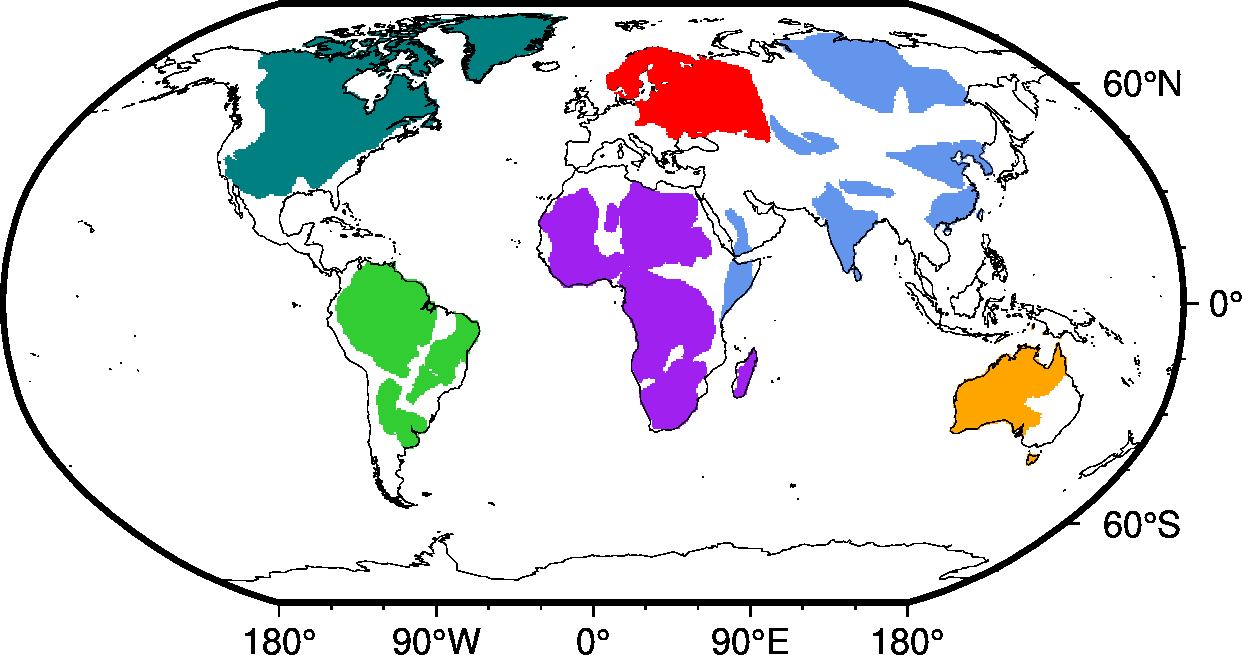

In [106]:
import os
import xarray as xr
print(os.getcwd())
import numpy as np

model ='gld504'
continent_names= [ 'LAU','AMZ','AUS', 'EAS', 'AFR', 'NCC', 'BAL' ]
# continents = ["North America",  "South America", "Australia", "Eurasia", "Africa"]
# continent_keys = [ "Ronov_NAm",  "Ronov_SAm", "Ronov_Aus", "Ronov_Eur", "Ronov_Afr"]
colors = [ '#008080', '#32CD32', 'orange',  '#6495ED', 'purple', '#6495ED', 'red']
#colors =['green','blue', 'red','cyan', 'brown']
# pd.DataFrame(continents_dt)
fig1 = pygmt.Figure()
region='d'
projection ='N10c'

for i, (continent, color) in  enumerate(zip(continent_names, colors)):  
    
   
    if continent not in ['NCC', 'BAL']:
        DT_files = glob.glob(f'./DTvsSediment/{model}/PlateFrameGrid_{continent}/*.nc')
    else:
        #DT_files = glob.glob(f'.././Model_data/{model}/PlateFrameGrid_{continent}/*.nc')
        DT_files = glob.glob(f'Input_Data_Cluster/{model}/PlateFrameGrid_{continent}/*.nc')
    sorted_DT_files = sort_files_by_age(DT_files, match_string='Grid')
    DT_nc = filepath_to_nc(sorted_DT_files)
    

    #-----------------------filter nc file upto 920 Ma and filter it with 920 Ma Nc file---------------#
    DT_nc = DT_nc.sel(age = slice(0,920))
    mask_920 = DT_nc.sel(age=920)
    DT_nc = DT_nc.where(mask_920)
    DT_nc['c'] = DT_nc['z'] * 0 + 100

    
    land_mask_file = glob.glob('./orogens/ne*/*.shp')
    print(land_mask_file)
    land_mask = gpd.read_file(land_mask_file[0])
    DT_nc=DT_nc.rio.write_crs("epsg:4326", inplace=True).rename({'lon':'x', 'lat':'y'})
    land_masked_dataset=DT_nc.rio.clip(geometries=land_mask.geometry, crs=4326, all_touched=True)

    # Suppose variables are 'lat' and 'lon'
    area_var =land_masked_dataset.sel(age=540)
    lat = area_var['y'].values
    lon = area_var['x'].values
    
    # Assume uniform spacing
    dlat = np.deg2rad(lat[1] - lat[0])
    dlon = np.deg2rad(lon[1] - lon[0])
    
    # Earth radius (m)
    R = 6_371_000
    
    # Compute area (m²) per latitude band
    # A = R^2 * Δλ * Δφ * cos(φ)
    area_per_lat = (R**2) * dlat * dlon * np.cos(np.deg2rad(lat))
    
    # Expand to 2D grid (lat × lon)
    area_grid = np.outer(area_per_lat, np.ones(len(lon)))
    
    # Example: mask a region or pixel group
    
    mask =  (area_var.c > 0.5) & (~np.isnan(area_var.c))  # e.g., threshold or region
    
    # Total area of that group
    total_area_m2 = np.sum(area_grid[mask])
    total_area_km2 = total_area_m2 / 1e6
    
    print(f"Continent {continent} : Total area = {total_area_km2 /1e6 :.2f} million km²")


    fig1.coast(region=region, projection=projection, shorelines="1/0.1p,black")
    pygmt.makecpt(cmap=color, series=[0,100] )
    fig1.grdimage(grid=land_masked_dataset.sel(age=920).c, projection=projection, region= region, nan_transparent="+znan", cmap=True , frame=False)
    fig1.basemap(region=region, projection =projection, frame=['ltSE', 'xaf', 'yaf'])
    
    #fig.legend()
fig1.show()

### Extract DT evolution for each continental block to Ronov's time step

In [108]:
import pygmt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import binned_statistic

model ='gld504'
continent_names= [ 'LAU','AMZ','AFR','AUS', 'EAS']
additional_continents = ['SIB', 'CON', 'KAL','WAC','BAL', 'NA', 'NCC']
colors =['forestgreen','blue', 'red','cyan', 'brown']



ronov_fpath=glob.glob('./DTvsSediment/*.xls')[0]
 #Keller sedimentary dataframe
ronov_keller_data = pd.read_excel(ronov_fpath)
ronov= ronov_keller_data.copy().iloc[:-1,:]

#ronov = resample_custom_intervals(ronov)

#---------------------------- Extract data to Ronov's Df--------------------------------------#
def extract_DT_to_ronov_steps(ronov_fpath, continent_names, model, continent_type ='main'):

   
    
    continents_dt ={}
    for continent in continent_names:
        #print(continent)
        
        if continent_type =='main':
            continental_DT_files = glob.glob(f'./DTvsSediment/{model}/PlateFrameGrid_{continent}/*.nc')
        else:
            #continental_DT_files = glob.glob(f'.././Model_data/{model}/PlateFrameGrid_{continent}/*.nc')
            continental_DT_files = glob.glob(f'Input_Data_Cluster/{model}/PlateFrameGrid_{continent}/*.nc')
        
        sorted_DT_files = sort_files_by_age(continental_DT_files, match_string='Grid')
        
        DT_nc = filepath_to_nc(sorted_DT_files)
        
    
        #-----------------------filter nc file upto 920 Ma and filter it with 920 Ma Nc file---------------#
        DT_nc = DT_nc.sel(age = slice(0,920))
        mask_920 = DT_nc.sel(age=920)
        DT_nc = DT_nc.where(mask_920)
        
        # Congo, Kalahari, WAC, Siberia and Baltica
    
        
    
        # -----------------------nc to spatially averaged dataframe------------------------#
        df = DT_nc.mean(dim=['lon','lat']).z.to_dataframe().reset_index()
    
        # Define a function that extracts, averages by interval
        def extract_average_by_interval(data_df, intervals_df,  tolerance=0):
            results = []
            for i, row in intervals_df.iterrows():
                low, high = row['t_age'] - tolerance, row['b_age'] + tolerance
                subset = data_df[(data_df['age'] >= low) & (data_df['age'] <= high)]
                
                if not subset.empty:
                    avg_val = subset['z'].mean()
                else:
                    # fallback: find nearest available age
                    target_age = (low + high) / 2  # midpoint of interval
                    nearest_idx = (data_df['age'] - target_age).abs().idxmin()
                    avg_val = data_df.loc[nearest_idx, 'z']
                
                results.append({
                    'b_age': row['b_age'],
                    't_age': row['t_age'],
                    continent: avg_val
                })
            
            return pd.DataFrame(results)
        
        # Example usage
        averaged_df = extract_average_by_interval(df, ronov, tolerance=1)
        continents_dt[continent] = averaged_df
  
    stepped_continental_DTs= pd.concat(continents_dt.values(), axis=1)#.drop(['age', 'interval'], axis=1)
    stepped_continental_DTs = stepped_continental_DTs.loc[:, ~stepped_continental_DTs.columns.duplicated()]
    # stepped_continental_DTs['b_age'] = ronov['b_age']
    # stepped_continental_DTs['t_age'] = ronov['t_age']
    return stepped_continental_DTs

stepped_continental_DT = extract_DT_to_ronov_steps(ronov, continent_names, model, continent_type ='main')
#print(stepped_continental_DT)
BaSiC_KaWA = extract_DT_to_ronov_steps(ronov, additional_continents, model, continent_type ='additional')
print(BaSiC_KaWA.head(), stepped_continental_DT.head(3))

       b_age      t_age          SIB         CON         KAL         WAC  \
0   5.333000   2.588000 -1200.244507   15.344584  374.211884 -262.905579   
1  23.030001   5.333000 -1169.392822   30.527864  378.977905 -243.855484   
2  33.900002  23.030001 -1095.994263   87.983200  412.553131 -186.570587   
3  56.000000  33.900002 -1178.464600  142.181793  465.702454 -152.547531   
4  66.000000  56.000000 -1050.850708  192.802734  468.155243  -77.906265   

          BAL          NA          NCC  
0 -767.462830 -521.618530 -1467.298584  
1 -739.948853 -568.727295 -1430.350342  
2 -668.786255 -645.561279 -1340.294189  
3 -707.511414 -699.019348 -1439.516357  
4 -563.525818 -668.935730 -1316.929565          b_age      t_age         LAU         AMZ         AFR         AUS  \
0   5.333000   2.588000 -573.591858 -160.790955 -197.683884 -144.904449   
1  23.030001   5.333000 -594.607361 -174.931656 -174.079575  -87.307106   
2  33.900002  23.030001 -624.280151 -190.565033 -101.532761   20.547514 

/Users/sd277/Library/CloudStorage/OneDrive-UniversityofWollongong/Final_Scripts_and_Figures
NA
EAS
AMZ
AUS
AFR
LAU
NCC
BAL
SIB
KAL
CON
WAC
5
(54, 3)
(54, 3)
(54, 3)
Bbox(x0=0.125, y0=0.10999999999999999, x1=0.47727272727272724, y1=0.3364705882352941) [0.35, 0.10999999999999999, 0.35227272727272724, 0.2264705882352941]


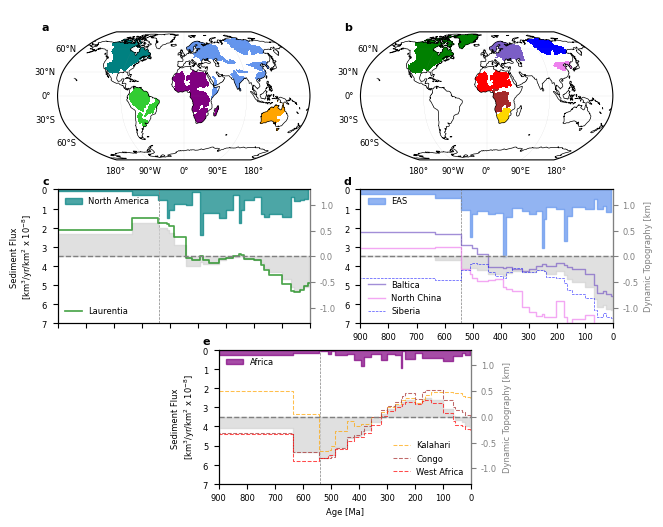

In [109]:
import os
import xarray as xr
print(os.getcwd())
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib import cm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as patches

# import pygmt
# import glob

# Matplotlib
incm = 1 / 2.54

model ='gld504'
continent_names= [ 'LAU', 'EAS',  'NCC', 'BAL', 'SIB', 'KAL',  'CON','WAC', ]
# continents = ["North America",  "South America", "Australia", "Eurasia", "Africa"]
# continent_keys = [ "Ronov_NAm",  "Ronov_SAm", "Ronov_Aus", "Ronov_Eur", "Ronov_Afr"]
colors = [ 'teal',   '#6495ED',  'violet', '#7B5EC6','blue', 'orange','brown', 'red']

#colors =['green','blue', 'red','cyan', 'brown']
# pd.DataFrame(continents_dt)




n_colors = 5
continentcolors = cm.rainbow(np.linspace(0, 1, n_colors))


#---------------------------------- Colored age axes corresponding to geological period--------------------------------#
age_intervals = [
    ("Neoproterozoic", 1000, 541, "#fc8d59"),
    ("Cambrian", 541, 485, "#91cf60"),
    ("Ordovician", 485, 444, "#1a9850"),
    ("Silurian", 444, 419, "#67a9cf"),
    ("Devonian", 419, 359, "#3690c0"),
    ("Carboniferous", 359, 299, "#0571b0"),
    ("Permian", 299, 252, "#fdae61"),
    ("Mesozoic", 252, 66, "#fee08b"),
    ("Cenozoic", 66, 0, "#ffffbf"),
]

ronov_fpath=glob.glob('./DTvsSediment/*.xls')[0]
#Keller sedimentary dataframe
ronov_keller_data = pd.read_excel(ronov_fpath)
ronov= ronov_keller_data.copy().iloc[:-1,:]

x_ronov = np.vstack([ronov["t_age"].values, ronov["b_age"].values]).T.flatten()
dt = ronov["b_age"].values - ronov["t_age"].values
dt[0] = np.nan  # Exclude Quaternary alluvium

# Repeat function (like Julia's repeat(..., inner=2))
def repeat_inner(arr):
    return np.repeat(arr, 2)



#compute cumulative stacked values for stacked histogram
def compute_cumulative_values_org(x, continent):
    # --- Stacked histogram (cumulative area plot) ---
    
    vol_cumulative = np.zeros((len(x), len(continent_keys)))
    # reverse order accumulation (like Julia)
    for i, key in enumerate(continent_keys):
        
        total = np.zeros(len(x))
        #total += repeat_inner(ronov[key].values / dt)
        total += repeat_inner(ronov[key].values / dt /contarea[i] *1e8)  # (contarea[i])area averaged continental sediments (km3/yr/km2) [::-1] reverses the order as reversed for continents
        vol_cumulative[:, i] = total
        #print(f'{key}:{ronov[key].head()}: {vol_cumulative}')
    return total, vol_cumulative

# Compute Neoproterozoic and  Phanerozoic mean

# --- Compute mean flux in given intervals ---
def compute_mean_flux(x, flux):
    """
    Compute mean flux for Neoproterozoic (1000–541 Ma)
    and Phanerozoic (541–0 Ma).
    """
    neo_mask = (x <= 1000) & (x >= 541)
    phan_mask = (x <= 541) & (x >= 0)

    neo_mean = np.nanmean(flux[neo_mask])
    phan_mean = np.nanmean(flux[phan_mask])
    return neo_mean, phan_mean


# --- Plot each continent by itself ---
continents = ["North America", 'EAS', "Africa"]
continent_keys = [ "Ronov_NAm", "Ronov_Eur", "Ronov_Afr"]
continentcolors = [ 'teal',  'cornflowerblue', 'purple']
#continentcolors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
DT_continent_keys = [  "LAU", "EAS", "AFR"]
contarea = [24.228E6,  53.4E6, 30.3E6]




# ------------------- Main plotting loop ------------------- #
fig, axes = plt.subplots(3, 2,
    figsize=(18.2*incm, 15*incm),
    sharey=True
)

axes= axes.ravel()

fig.delaxes(axes[0])   # remove the normal axes at 0th index
fig.delaxes(axes[1])    # remove the normal axes index 1



# add geoaxes in its place
geo_ax1= fig.add_subplot(3, 2, 1, projection= ccrs.Robinson())   # row, col, index
geo_ax2= fig.add_subplot(3, 2, 2, projection= ccrs.Robinson())

for k, geo_ax in enumerate([geo_ax1, geo_ax2]):


    if k ==0:
        continent_lbs = ['NA',  'EAS', 'AMZ','AUS', 'AFR' ]
        colors = ['teal', 'cornflowerblue','limegreen','orange','purple']
        geo_text='a'
    else:
        continent_lbs = ['LAU',   'NCC', 'BAL', 'SIB', 'KAL',  'CON','WAC', ]
        colors= [ 'green',  'violet', '#7B5EC6','blue', 'gold','brown', 'red']
        geo_text='b'
    #print(f'k:{k}, continent:{continent_lbs}')  
    #--------------------Continent sepcific Color Plots-------------------#
    for j, (continent, color) in enumerate(zip(continent_lbs, colors)):
        print(continent)
        
       
        if continent not in ['NA','NCC', 'BAL', 'SIB', 'KAL', 'WAC', 'CON']:
            DT_files = glob.glob(f'./DTvsSediment/{model}/PlateFrameGrid_{continent}/*.nc')
        else:
            #DT_files = glob.glob(f'.././Model_data/{model}/PlateFrameGrid_{continent}/*.nc')
            DT_files = glob.glob(f'Input_Data_Cluster/{model}/PlateFrameGrid_{continent}/*.nc')
        sorted_DT_files = sort_files_by_age(DT_files, match_string='Grid')
        DT_nc = filepath_to_nc(sorted_DT_files)
        
    
        #-----------------------filter nc file upto 920 Ma and filter it with 920 Ma Nc file---------------#
        DT_nc = DT_nc.sel(age = slice(0,920))
        mask_920 = DT_nc.sel(age=920)
        DT_nc = DT_nc.where(mask_920)
        DT_nc['c'] = DT_nc['z'] * 0 + 100
    
        
        land_mask_file = glob.glob('./orogens/ne*/*.shp')
        # print(land_mask_file)
        land_mask = gpd.read_file(land_mask_file[0])
        DT_nc=DT_nc.rio.write_crs("epsg:4326", inplace=True).rename({'lon':'x', 'lat':'y'})
        land_masked_dataset=DT_nc.rio.clip(geometries=land_mask.geometry, crs=4326, all_touched=True)
    
        # Select 920 Ma slice
        c_920 = land_masked_dataset.sel(age=920)['c']
    
        # ---------------- Plotting ---------------- #
        # Use .plot.pcolormesh for raster
        cmap= ListedColormap([color])
        c_920.plot.pcolormesh( cmap=cmap, transform=ccrs.PlateCarree(),add_colorbar=False, ax=geo_ax)

    # Coastlines and decorations

    
    geo_ax.coastlines(linewidth=0.5, color='black')
    geo_ax.set_global()  # or ax.set_extent(region, crs=ccrs.PlateCarree())
    # geo_ax.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5)
    # Create gridlines and turn off labels on top/right
    gl = geo_ax.gridlines(draw_labels=True, linewidth=0.1, color='gray', alpha=0.5,)
    gl.xlocator = matplotlib.ticker.FixedLocator(range(-180, 181, 90))  # longitudes every 90°
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 6, 'color': 'black'}
    gl.ylabel_style = {'size': 6, 'color': 'black'}
    geo_ax.tick_params(top=False, right=False, labeltop=False, labelright=False)
    geo_ax.set_title(' ')
    geo_ax.text(-0.035, 1.075, geo_text, transform=geo_ax.transAxes,
                fontsize=8, fontweight='bold', va='top', ha='right')
            


    #--------------DT AND SEDIMENT PLOT----------------__________#
    
# delete last axes
fig.delaxes(axes[-1])
# #labels
fig_labels =['c','d','e']

# fig, axes = plt.subplots(5, 1, figsize=(8*incm,19*incm), sharex=True)



total_ronov, vol_cumulative_ronov = compute_cumulative_values_org(x_ronov, continent_keys)

total_DT, vol_cumulative_DT = compute_cumulative_values_org(x_ronov, DT_continent_keys)
#print(len(x_ronov), len(vol_cumulative_ronov[:,0]), len(vol_cumulative_DT))

print(len(fig.axes))
for i, ax in enumerate(fig.axes):
   
    if i >2:   # geoindexes
        ax.tick_params(top=False, right=False, labeltop=False, labelright=False)
        
        continue
        
    else:
        ax.axvline(x=540, c='grey', linewidth=0.5, linestyle='--')
        print(vol_cumulative_ronov.shape)
        ax.fill_between(x_ronov, vol_cumulative_ronov[:, i], step="mid", label=continents[i], color=continentcolors[i], alpha=0.7)
        
        ax1=ax.twinx()
        ax1.fill_between(x_ronov, repeat_inner(stepped_continental_DT[DT_continent_keys[i]].values), color='lightgrey', alpha=0.7)
        #legend
        ax.legend(loc='upper left', frameon=False, facecolor="None", fontsize=6)
        
        ax.set_ylabel("Sediment Flux \n[km$^3$/yr/km$^2$ x 10$^{-8}$]", fontsize=6)
        ax.set_xlim(0, 900)

        ax1.set_ylim(-1200, 1200)
        # using a ScalarFormatter
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-3, 4)) # Display scientific notation for values outside 10^-3 to 10^4
        
        ax.yaxis.set_major_formatter(formatter)
        ax.set_ylim(0, 7) 

        #ax.ticklabel_format(style='sci', axis='y', scilimits=(0, -8)) 
        #plot additional continental stepped DT
        if i==2:
            ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['KAL'].values), label='Kalahari', color='orange', alpha=0.7, linestyle='--', linewidth=0.75)
            ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['CON'].values), label='Congo', color='brown', alpha=0.7, linestyle='--',linewidth=0.75)
            ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['WAC'].values), label='West Africa', color='red', alpha=0.7, linestyle='--',linewidth=0.75)
            ax1.legend(loc="lower right", frameon=False, facecolor="None", fontsize=6)
                        

        if i==1:
            ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['BAL'].values), label='Baltica', color='#7B5EC6', alpha=0.7, linestyle='-',linewidth=1)
            ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['NCC'].values), label='North China', color='violet', alpha=0.7, linestyle='-',linewidth=1)
            ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['SIB'].values), label='Siberia', color='blue', alpha=0.7, linestyle='--',linewidth=0.5)
            
            ax1.legend(loc="lower left", frameon=False, facecolor="None", fontsize=6)
            ax1.tick_params(axis='y', right=True, labelright=True)
            ax1.set_ylabel('')
            ax.tick_params(axis='y',left=True, labelleft=True)
            ax.set_ylabel('')
        elif i==0:
            ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['NA'].values), label='Laurentia', color='green', alpha=0.7, linestyle='-',linewidth=1.25)
            ax1.legend(loc="lower left", frameon=False, facecolor="None", fontsize=6)
            ax.tick_params(axis='x', bottom=True, labelbottom=False)
            ax.tick_params(axis='y',left=True, labelleft=True)
            ax1.set_ylabel('')
           
            
            

        # ticks fontsize
        ax.tick_params(axis='both', which='major', labelsize=6)
        ax1.tick_params(axis='both', which='major', labelsize=6)
        
        
        ax1.set_ylim(-1300, 1300)
        ax.invert_xaxis()
        ax.invert_yaxis()
        #ax.set_title(continents[i])
        if i >=2:
            ax.set_xlabel('Age [Ma]', fontsize=6)
        
        ax1.axhline(y=0, c='grey', linewidth=1, linestyle='--')
        if i>0:
            ax1.set_ylabel("Dynamic Topography [km]", color='grey', fontsize=6)


        def meters_to_km(x, pos):
            return f"{x/1000:.1f}"  # divide by 1000 to get km
               
        #ax1.set_ylabel("Secondary Y", color="red")
        ax1.tick_params(axis="y", colors="grey")
        ax1.yaxis.set_major_formatter(FuncFormatter(meters_to_km))
        #ax1.ticklabel_format(style='sci', axis='y', scilimits=(-3, 3)) 
        ax1.spines["right"].set_color("grey")
        ax.text(-0.035, 1.1, fig_labels[i], transform=ax.transAxes,
            fontsize=8, fontweight='bold', va='top', ha='right')

# Get its current position
pos = fig.axes[-1].get_position()
new_pos = [pos.x0+0.225, pos.y0, pos.width, pos.height]
fig.axes[-1].set_position(new_pos)
print(pos, new_pos)
# fig.axes[-1].set_position(p)

#ax1.set_position(box)


#fig.subplots_adjust(wspace=0.15, hspace=0.15) # did not work while shifting the position of last subplot
plt.savefig('./ExtendedDataFigures/EDF8-SedimentvsDT_M6_model_continental_blocks.pdf', dpi=600, bbox_inches='tight')
plt.show()


# Continent-wise sedimentary preservation volume (km3/yr) vs dynamic topography

   b_age  t_age         LAU
0    540      0 -165.149139
1   1000    540  544.485962
   b_age  t_age         EAS
0    540      0 -464.558228
1    900    540  -62.290993
   b_age  t_age         AMZ
0    120      0 -138.369736
1    380    120  118.562851
2    540    380 -298.395691
3    900    540  318.888733
   b_age  t_age         AUS
0    120      0  -25.447199
1    280    120  135.914642
2    540    280 -229.860184
3    900    540  305.146912
   b_age  t_age         AFR
0     60      0 -133.362076
1    300     60  270.302002
2    900    300 -502.840424


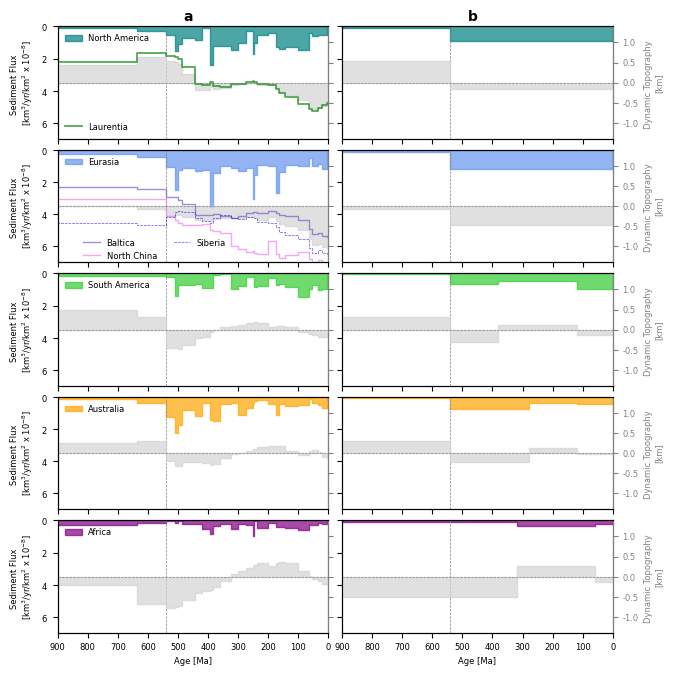

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter



# --- Setup ---
continents     = ["North America","Eurasia","South America","Australia","Africa"]
continent_keys = ["Ronov_NAm","Ronov_Eur","Ronov_SAm","Ronov_Aus","Ronov_Afr"]
#continent_names= [ 'LAU','EAS', 'AMZ','AUS', 'AFR']
DT_keys        = ["LAU","EAS","AMZ","AUS","AFR"]
colors         = ['teal','cornflowerblue','limegreen','orange','purple']
contarea       = [24.228E6,53.4E6,18.28E6,8.8015E6,30.3E6]
#fig_labels     = ['a','b','c','d','e']
fig_labels     = ['a','b']

# --- Cycles definitions ---
ronov_cycles = {
    'Ronov_NAm': [(540,0),  (1000,540)],
    'Ronov_Eur': [(540,0), (900,540),],
    #'Ronov_SAm': [(180,0),(380,180),(540,380), (900,540),], #old
    #'Ronov_Aus': [(180,0),(320,180),(540,320),(900,540)], #old
    'Ronov_SAm': [(120,0),(380,120),(540,380), (900,540),],
    'Ronov_Aus': [(120,0),(280,120),(540,280),(900,540)],
    'Ronov_Afr': [(60,0),(320,60),(900,320)]
}
dt_cycles = {
    'LAU': [(540,0),  (1000,540)],
    'EAS': [(540,0), (900,540),],
    # 'AMZ': [(180,0),(380,180),(540,380), (900,540)], #old
    # 'AUS': [(180,0),(320,180),(540,320),(900,540)],  #old
    'AMZ': [(120,0),(380,120),(540,380), (900,540),],
    'AUS': [(120,0),(280,120),(540,280),(900,540)],
    'AFR': [(60,0),(300,60),(900,300)]
}

#-----orginal ronov cycles----------------------------#
ronov_df = pd.read_excel(glob.glob('DTvsSediment/*.xls')[0])
org_ronov_cycles = { continent_key : list(zip(ronov_df['b_age'], ronov_df['t_age'])) for continent_key  in continent_keys}
org_dt_cycles = { dt_key : list(zip(ronov_df['b_age'], ronov_df['t_age'])) for dt_key  in DT_keys}

# --- Aggregate to custom cycles ---
def aggregate_to_custom_cycles(df, intervals, cont):
    results = []
    for (b, t) in intervals:
        mask = (df["b_age"] <= b) & (df["t_age"] >= t)
        subset = df.loc[mask, [cont]]
        if not subset.empty:
            if "Ronov" in cont:   # sediments → sum
                val = subset[cont].sum()
            elif "DT" in cont:    # topography → mean
                val = subset[cont].mean()
            else:
                val = subset[cont].mean()
            results.append({"b_age": b, "t_age": t, cont: val})
    return pd.DataFrame(results)

# --- Helpers ---
def repeat_inner(arr): return np.repeat(arr, 2)

def compute_cumulative_values(x, df, continent, dt, cont_area):
    vol_cumulative = np.zeros((len(x), len(continent)))
    for i, key in enumerate(continent):
        total = repeat_inner(df[key].values / dt / cont_area *1e8) 
        vol_cumulative[:, i] = total 
    return total, vol_cumulative

def compute_mean_flux(x, flux):
    neo_mask = (x <= 1000) & (x >= 541)
    phan_mask = (x <= 541) & (x >= 0)
    return np.nanmean(flux[neo_mask]), np.nanmean(flux[phan_mask])

def meters_to_km(x, pos): return f"{x/1000:.1f}"

# compute DT and sedimentary flux at ROnov's time steps
x_ronov = np.vstack([ronov["t_age"].values, ronov["b_age"].values]).T.flatten()
# dt = ronov["b_age"].values - ronov["t_age"].values
# dt[0] = np.nan  # Exclude Quaternary alluvium

total_ronov, vol_cumulative_ronov = compute_cumulative_values_org(x_ronov, continent_keys)

total_DT, vol_cumulative_DT = compute_cumulative_values_org(x_ronov, DT_continent_keys)


fig, axes = plt.subplots(5, 2, figsize=(18.2*incm,20*incm), sharex=True, sharey=True)

for j in range(2):
    for i, ax in enumerate(axes[:,j]):
        if j ==1:
        
        # aggregate
            ronov_res = aggregate_to_custom_cycles(ronov, ronov_cycles[continent_keys[i]], continent_keys[i])
            
            dt_res    = aggregate_to_custom_cycles(stepped_continental_DT, dt_cycles[DT_keys[i]], DT_keys[i])
            print(dt_res)
            
            # expand steps
            x_ronov_stepped = np.vstack([ronov_res["t_age"].values, ronov_res["b_age"].values]).T.flatten()
            dt_vals = ronov_res["b_age"].values - ronov_res["t_age"].values
            
            total_ronov, vol_cum = compute_cumulative_values(x_ronov_stepped, ronov_res, [continent_keys[i]], dt_vals, contarea[i])

           
            
        
            # plot sediment flux
            ax.axvline(x=540, c='grey', linewidth=0.5, linestyle='--')
           
            
            ax.fill_between(x_ronov_stepped, vol_cum[:,0], step="mid", color=colors[i], alpha=0.7, label=continents[i])
            # ax.set_ylabel("Sediment Flux \n[km$^3$/yr/km$^2$ x 10$^{-8}$]", fontsize=6)
            ax.set_xlim(0,900)
            ax.set_ylim(0, 7)
            ax.invert_xaxis()
            ax.invert_yaxis()
        
            # plot DT
            ax1 = ax.twinx()
            ax1.set_ylim(-1400, 1400)
            ax1.fill_between(x_ronov_stepped, repeat_inner(dt_res[DT_keys[i]].values), color='lightgrey', alpha=0.7)
            
            def meters_to_km(x, pos):
                return f"{x/1000:.1f}"  # divide by 1000 to get km
                   
            ax1.tick_params(axis="y", colors="grey")
            ax1.yaxis.set_major_formatter(FuncFormatter(meters_to_km))
            ax1.spines["right"].set_color("grey")
            ax1.set_ylabel("Dynamic Topography \n[km]", color='grey', fontsize=6)
            # labels
            if i == 4: 
                ax.set_xlabel('Age [Ma]', fontsize=6)
                        
            ax1.set_ylabel("Dynamic Topography \n[km]", color='grey', fontsize=6)
             # ticks fontsize
            ax1.axhline(y=0, c='grey', linewidth=0.5, linestyle='--')
            ax.tick_params(axis='both', which='major', labelsize=6)
            ax1.tick_params(axis='both', which='major', labelsize=6)
            
        else:
            ax.axvline(x=540, c='grey', linewidth=0.5, linestyle='--')
            #ax.fill_between(x, vol_cumulative_ronov[:, i], step="mid", label=continents[i], color=continentcolors[i], alpha=0.7)
            ax.fill_between(x_ronov, vol_cumulative_ronov[:, i], step="mid", label=continents[i], color=colors[i], alpha=0.7)
            #ax.fill_between(x, repeat_inner(ronov[continent_keys[i]].values), label='Sediment Volume', color=continentcolors[i], alpha=0.7)
            
            ax1=ax.twinx()
            ax1.fill_between(x_ronov, repeat_inner(stepped_continental_DT[DT_keys[i]].values), color='lightgrey', alpha=0.7)
            #legend
            ax.legend(loc='upper left', frameon=False, facecolor="None", fontsize=6)
            
            ax.set_ylabel("Sediment Flux \n[km$^3$/yr/km$^2$ x 10$^{-8}$]", fontsize=6)
            ax.set_xlim(0, 900)
            if i >2:
                #ax.set_ylim(0,0.8)
                ax1.set_ylim(-700,900)
            elif i==2:
                #ax.set_ylim(0,2)
                ax1.set_ylim(-700,1200)
            else:
                #ax.set_ylim(0, 7)
                ax1.set_ylim(-1200, 1200)
            #ax.set_ylim(0, 7)
            # Configure the x-axis to display tick labels in scientific notation
            # using a ScalarFormatter
            formatter = ScalarFormatter(useMathText=True)
            formatter.set_scientific(True)
            formatter.set_powerlimits((-3, 4)) # Display scientific notation for values outside 10^-3 to 10^4
            
            ax.yaxis.set_major_formatter(formatter)
            ax.set_ylim(0, 7) 
    
            #ax.ticklabel_format(style='sci', axis='y', scilimits=(0, -8)) 
            #plot additional continental stepped DT
            if i==4:
                # ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['KAL'].values), label='Kalahari', color='k', alpha=0.7, linestyle='--', linewidth=0.75)
                # ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['CON'].values), label='Congo', color='brown', alpha=0.7, linestyle='--',linewidth=0.75)
                # ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['WAC'].values), label='West Africa', color='chocolate', alpha=0.7, linestyle='--',linewidth=0.75)
                # ax1.legend(loc="lower right", frameon=False, facecolor="None")
                pass
    
            elif i==1:
                ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['BAL'].values), label='Baltica', color='#7B5EC6', alpha=0.7, linestyle='-',linewidth=1)
                ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['NCC'].values), label='North China', color='violet', alpha=0.7, linestyle='-',linewidth=1)
                ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['SIB'].values), label='Siberia', color='blue', alpha=0.7, linestyle='--',linewidth=0.5)
                
               # ax1.legend(loc="lower left", frameon=False, facecolor="None", fontsize=6, ncol=1)
                ax1.legend(loc='best', bbox_to_anchor=(0.15, -0.05, 0.5, 0.5), frameon=False, facecolor="None", fontsize=6, ncol=2)
                
            elif i==0:
                ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['NA'].values), label='Laurentia', color='green', alpha=0.7, linestyle='-',linewidth=1.25)
                ax1.legend(loc="lower left", frameon=False, facecolor="None", fontsize=6)
    
            
            
            
            ax1.set_ylim(-1400, 1400)
            ax.invert_xaxis()
            ax.invert_yaxis()
            #ax.set_title(continents[i])
            if i ==4:
                ax.set_xlabel('Age [Ma]', fontsize=6)
            
            ax1.axhline(y=0, c='grey', linewidth=0.5, linestyle='--')
            
    
            def meters_to_km(x, pos):
                return f"{x/1000:.1f}"  # divide by 1000 to get km
                   
            #ax1.set_ylabel("Secondary Y", color="red")
            ax1.tick_params(axis="y", colors="grey")
            ax1.yaxis.set_major_formatter(FuncFormatter(meters_to_km))
            ax1.spines["right"].set_color("grey")
            ax1.tick_params(axis='y', right=True, labelright=False)
            # ticks fontsize
            ax.tick_params(axis='both', which='major', labelsize=6)
            ax1.tick_params(axis='both', which='major', labelsize=6)
    
        if i==0:
            #     ax1.axvspan(start, end, ymin=0, ymax=0.1, color=color, zorder=0, clip_on=False)
            ax.text(0.5, 1.15, fig_labels[j], transform=ax.transAxes,
                fontsize=10, fontweight='bold', va='top', ha='right')

fig.subplots_adjust(wspace=0.05, hspace=0.1)
plt.savefig('./MainFigures/Figure4-SedimentvsDT-in-Ronov-DTcycles_M6_model.pdf', dpi=600, bbox_inches='tight')
plt.show()

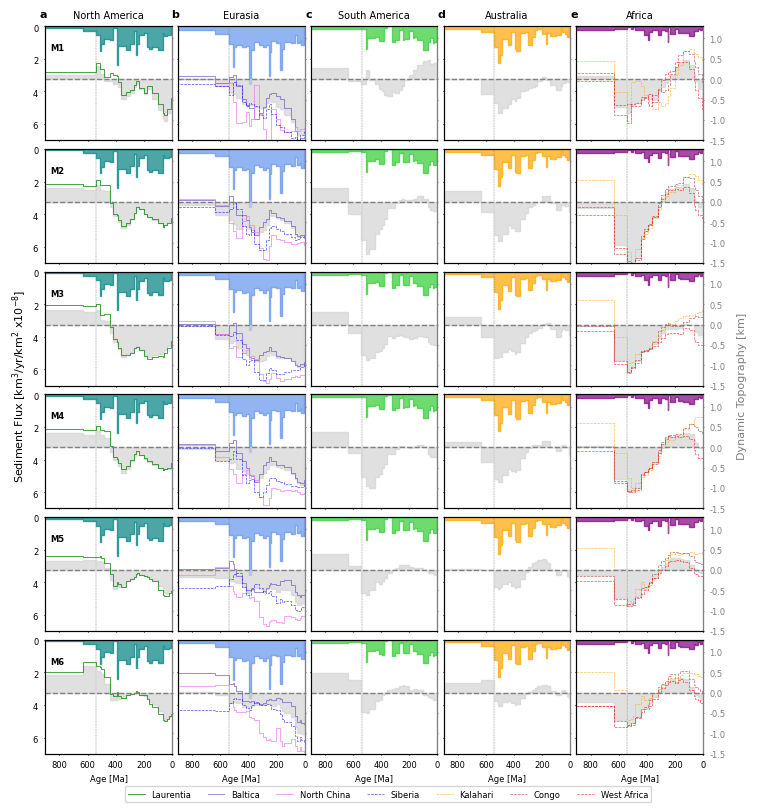

In [105]:
from matplotlib import cm
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as patches

incm = 1 / 2.54

n_colors = 5
continentcolors = cm.rainbow(np.linspace(0, 1, n_colors))

#---------------------------------- Colored age axes corresponding to geological period--------------------------------#
age_intervals = [
    ("Neoproterozoic", 1000, 541, "#fc8d59"),
    ("Cambrian", 541, 485, "#91cf60"),
    ("Ordovician", 485, 444, "#1a9850"),
    ("Silurian", 444, 419, "#67a9cf"),
    ("Devonian", 419, 359, "#3690c0"),
    ("Carboniferous", 359, 299, "#0571b0"),
    ("Permian", 299, 252, "#fdae61"),
    ("Mesozoic", 252, 66, "#fee08b"),
    ("Cenozoic", 66, 0, "#ffffbf"),
]


# Repeat function (like Julia's repeat(..., inner=2))
def repeat_inner(arr):
    return np.repeat(arr, 2)



#compute cumulative stacked values for stacked histogram
def compute_cumulative_values(x, continent):
    # --- Stacked histogram (cumulative area plot) ---
    
    vol_cumulative = np.zeros((len(x), len(continent_keys)))
    # reverse order accumulation (like Julia)
    for i, key in enumerate(continent_keys):
        
        total = np.zeros(len(x))
        #total += repeat_inner(ronov[key].values / dt)
        total += repeat_inner(ronov[key].values *1e8 / dt /contarea[i] )  # (contarea[i])area averaged continental sediments (km3/yr/km2) [::-1] reverses the order as reversed for continents
        vol_cumulative[:, i] = total
        #print(f'{key}:{ronov[key].head()}: {vol_cumulative}')
    return total, vol_cumulative

# Compute Neoproterozoic and  Phanerozoic mean

# --- Compute mean flux in given intervals ---
def compute_mean_flux(x, flux):
    """
    Compute mean flux for Neoproterozoic (1000–541 Ma)
    and Phanerozoic (541–0 Ma).
    """
    neo_mask = (x <= 1000) & (x >= 541)
    phan_mask = (x <= 541) & (x >= 0)

    neo_mean = np.nanmean(flux[neo_mask])
    phan_mean = np.nanmean(flux[phan_mask])
    return neo_mean, phan_mean


# --- Plot each continent by itself ---
continents = ["North America",  "Eurasia","South America", "Australia",  "Africa"]
continent_keys = [ "Ronov_NAm", "Ronov_Eur",  "Ronov_SAm", "Ronov_Aus", "Ronov_Afr"]
continentcolors = [ 'teal', 'cornflowerblue','limegreen', 'orange',   'purple']
#continentcolors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
DT_continent_keys = [  "LAU", "EAS", "AMZ", "AUS",  "AFR"]
additional_continents = ['SIB', 'CON', 'KAL','WAC','BAL', 'NA', 'NCC']
contarea = [24.228E6, 53.4E6, 18.28E6, 8.8015E6,   30.3E6]
models=[ 'gld421','gld428', 'gld431', 'gld434', 'gld486', 'gld504']
model_labels =['M1', 'M2', 'M3', 'M4', 'M5', 'M6']
#labels
fig_labels =['a','b','c','d','e','f']

fig, axes = plt.subplots(6, 5, figsize=(20*incm,24*incm), sharex=True, sharey=True)

def sync_ylim(ax_list):
    """Synchronize ylim across multiple twin axes"""
    # find global min/max
    ymin = min(ax.get_ylim()[0] for ax in ax_list)
    ymax = max(ax.get_ylim()[1] for ax in ax_list)
    for ax in ax_list:
        ax.set_ylim(ymin, ymax)

secondary_axes =[]
for j, model in enumerate(models):
    

    ronov=pd.read_excel(glob.glob('DTvsSediment/*.xls')[0]).iloc[:-1,:]
   
    stepped_continental_DT = extract_DT_to_ronov_steps(ronov, DT_continent_keys, model, continent_type ='main')
    BaSiC_KaWA = extract_DT_to_ronov_steps(ronov, additional_continents, model,continent_type ='additional')
    
    x_ronov = np.vstack([ronov["t_age"].values, ronov["b_age"].values]).T.flatten()
    
    dt = ronov["b_age"].values - ronov["t_age"].values
    dt[0] = np.nan  # Exclude Quaternary alluvium
    
    
    total_ronov, vol_cumulative_ronov = compute_cumulative_values_org(x_ronov, continent_keys)
    
    total_DT, vol_cumulative_DT = compute_cumulative_values_org(x_ronov, DT_continent_keys)

    
    
    for i, ax in enumerate(axes[j].flatten()):
       
        ax.axvline(x=540, c='grey', linewidth=0.35, linestyle='--')
        #ax.fill_between(x, vol_cumulative_ronov[:, i], step="mid", label=continents[i], color=continentcolors[i], alpha=0.7)
        ax.fill_between(x_ronov, vol_cumulative_ronov[:, i], step="mid", label=continents[i], color=continentcolors[i], alpha=0.7)
        #ax.fill_between(x, repeat_inner(ronov[continent_keys[i]].values), label='Sediment Volume', color=continentcolors[i], alpha=0.7)
        
        ax1=ax.twinx()
        
        ax1.fill_between(x_ronov, repeat_inner(stepped_continental_DT[DT_continent_keys[i]].values), color='lightgrey', alpha=0.7)
        #ax.set_xlabel("Age (Ma)")
        
        ax.set_xlim(0, 900)
        
        # Configure the x-axis to display tick labels in scientific notation
        # using a ScalarFormatter
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-3, 4)) # Display scientific notation for values outside 10^-3 to 10^4
        
        ax.yaxis.set_major_formatter(formatter)
        ax.set_ylim(0, 7) 

        #ax.ticklabel_format(style='sci', axis='y', scilimits=(0, -8)) 
        #plot additional continental stepped DT
        if i==4:
            ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['KAL'].values), label='Kalahari', color='orange', alpha=0.7, linestyle='--', linewidth=0.5)
            ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['CON'].values), label='Congo', color='brown', alpha=0.7, linestyle='--',linewidth=0.5)
            ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['WAC'].values), label='West Africa', color='red', alpha=0.7, linestyle='--',linewidth=0.5)
            #ax1.legend(loc="lower right", frameon=False, facecolor="None")

        elif i==1:
            ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['BAL'].values), label='Baltica', color='#7B5EC6', alpha=0.7, linestyle='-',linewidth=0.75)
            ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['NCC'].values), label='North China', color='violet', alpha=0.7, linestyle='-',linewidth=0.75)
            ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['SIB'].values), label='Siberia', color='blue', alpha=0.7, linestyle='--',linewidth=0.5)
            
            #ax1.legend(loc="lower left", frameon=False, facecolor="None")
        elif i==0:
            ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['NA'].values), label='Laurentia', color='green', alpha=0.7, linestyle='-',linewidth=0.75)
            #ax1.legend(loc="lower left", frameon=False, facecolor="None")

        ax1.set_ylim(-1500, 1300)
        ax.invert_xaxis()
        ax.invert_yaxis()
        
        ax1.axhline(y=0, c='grey', linewidth=1, linestyle='--')

        def meters_to_km(x, pos):
            return f"{x/1000:.1f}"  # divide by 1000 to get km
               
        #ax1.set_ylabel("Secondary Y", color="red")
        ax1.tick_params(axis="y", colors="grey")
        ncols = axes.shape[1]
        col = i % ncols
        if col != ncols - 1:
            ax1.tick_params(labelleft=False, labelright=False)
        ax1.set_ylabel("") 
        ax1.yaxis.set_major_formatter(FuncFormatter(meters_to_km))
        #ax1.ticklabel_format(style='sci', axis='y', scilimits=(-3, 3)) 
        ax1.spines["right"].set_color("grey")

        # # --- Draw colored rectangles ---
        # for label, start, end, color in age_intervals:
        ax.tick_params(axis='both', which='major', labelsize=6, length=1)  # major ticks
        ax1.tick_params(axis='both', which='major', labelsize=6, length=1)  # minor ticks (if any)
        #     ax1.axvspan(start, end, ymin=0, ymax=0.1, color=color, zorder=0, clip_on=False)
        if j==0:
            ax.text(0.01, 1.15, fig_labels[i], transform=ax.transAxes,
                fontsize=8, fontweight='bold', va='top', ha='right')
            ax.set_title(continents[i], fontsize=7)
         
        # Collect all handles and labels once for the legend
        if j==5:
            secondary_axes.append(ax1)
            ax.set_xlabel('Age [Ma]', fontsize=6)
            
        if i==0:
             ax.text(0.15, 0.85, model_labels[j], transform=ax.transAxes,
                    fontsize=6, va='top', ha='right', fontweight='bold')
fig.supylabel(r"Sediment Flux [km$^3$/yr/km$^2$ x10$^{-8}$]", fontsize=8)
# use fig-level text as pseudo-supylable for right-axis
fig.text(x=0.95, y=0.5, s=r"Dynamic Topography [km]", size=8, rotation=90, ha='center', va='center', color='grey')
            
handles_labels = [ax1.get_legend_handles_labels() for ax1 in secondary_axes]
handles, labels = zip(*handles_labels)
handles = [h for sublist in handles for h in sublist]
labels = [l for sublist in labels for l in sublist]
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.08), ncol=7, fontsize=6)
        
fig.subplots_adjust(left=0.065, wspace=0.05, hspace=0.075)
plt.savefig('./ExtendedDataFigures/EDF9-SedimentvsDT_all_models.pdf', dpi=600, bbox_inches='tight')
plt.show()

/var/folders/5l/4gfdgm4927n2gx3mj9g81_4r0000gs/T/ipykernel_20287/1043756394.py:9: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  (gpml_cts[
/var/folders/5l/4gfdgm4927n2gx3mj9g81_4r0000gs/T/ipykernel_20287/1043756394.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


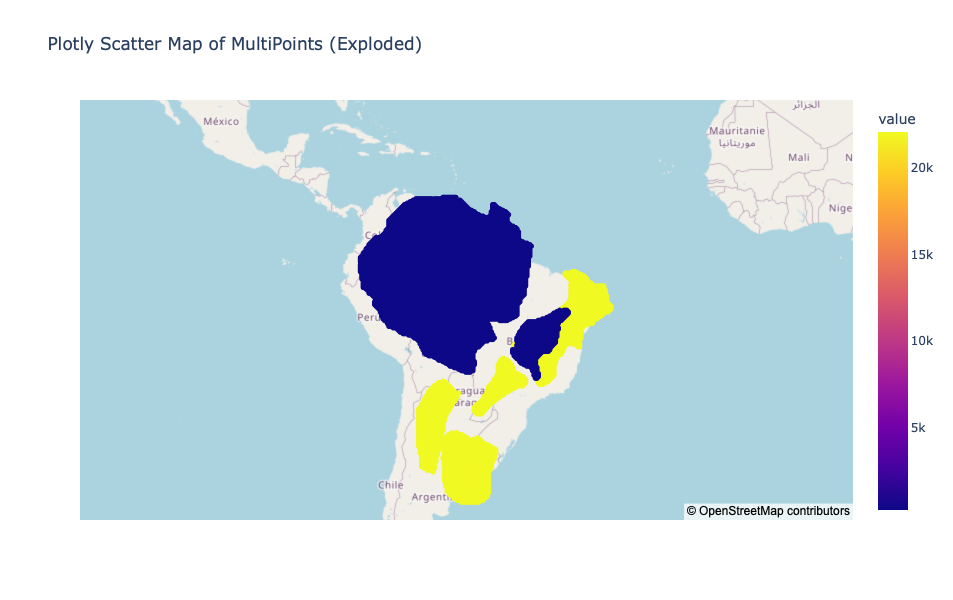

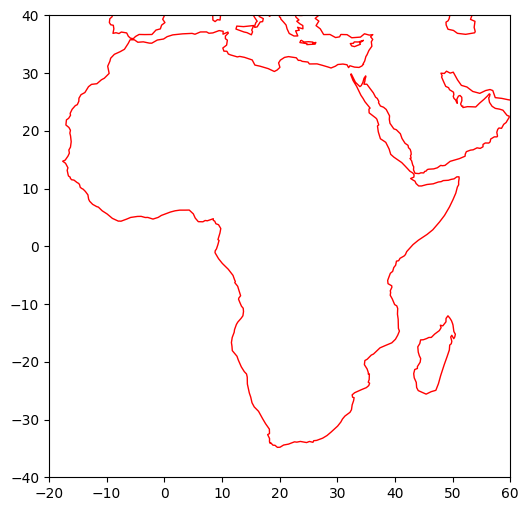

In [5]:
import plotly.express as px
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(1,1, figsize=(10,6))
gpml_cts =gpd.read_file(f'.././Reconstructions/For_gld504/lat_lon_velocity_domain_720_1440_with_plate_IDs_with_ages_for_gld504.gpml')
gpml_cts = gpml_cts[gpml_cts.value.astype(str).str.startswith('2')]
gpml_cts['timePosition'] = gpml_cts['timePosition'].astype(int)
gpml_cts = gpml_cts[gpml_cts.timePosition>=900]
gpml_cts.geometry = gpml_cts.geometry.map(lambda geom: transform(lambda x, y: (y, x), geom))
(gpml_cts[
 (gpml_cts.value.astype(str).str.startswith('7703')) | 
 (gpml_cts.value.astype(str).str.startswith('715')) | 
 (gpml_cts.value.astype(str).str.startswith('714')) | 
 (gpml_cts.value.astype(str).str.startswith('76')) |
 (gpml_cts.value.astype(str).str.startswith('77144')) |
 (gpml_cts.value.astype(str).str.startswith('77141')) 
 
 ].plot(ax=ax1)
)#


# You can update traces to enable clustering, for example:
# fig.update_traces(cluster=dict(enabled=True)) 


#gpml_cts[(gpml_cts.value.astype(str).str.startswith('6'))].plot(ax=ax1, facecolor='cyan')
land_mask.plot(ax= ax1, facecolor="None", edgecolor='red')
plt.xlim(-20, 60)
plt.ylim(-40, 40)
np.unique(gpml_cts.value)
fig.show()
#gpml_cts[gpml_cts.value.astype(str).str.startswith('7')]

exploded_gdf = gpml_cts.explode(index_parts=False).reset_index(drop=True)

#%matplotlib inline
fig_px=px.scatter_map(
    exploded_gdf,
    lat=exploded_gdf.geometry.y,
    lon=exploded_gdf.geometry.x,
    color="value",         # Color points based on their original group name,      # Size points based on a value from the original row
    hover_name="value",    # Show name on hover
    title="Plotly Scatter Map of MultiPoints (Exploded)",
    map_style="open-street-map", # Use a tile map style
    width=1000, 
    height=600,
    zoom=2
)
fig_px.show()

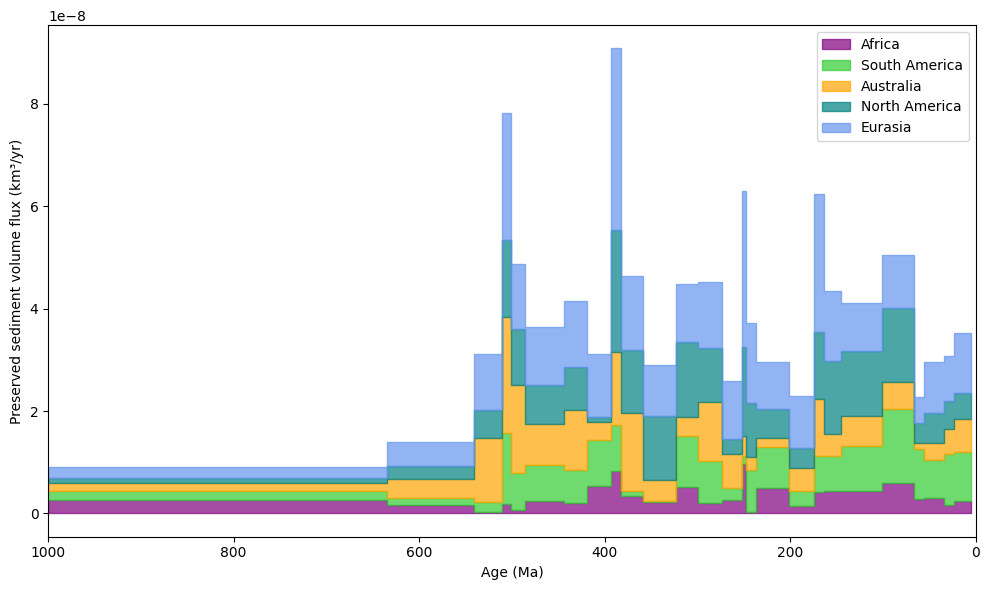

In [88]:
import matplotlib.pyplot as plt
import numpy as np

df =ronov

intervals = df['interval']
b_age = df['b_age']
t_age = df['t_age']

x = np.repeat(t_age.values, 2)

x = np.append(x, b_age.values[-1])  # close last interval


continent_keys = [
    'Ronov_Afr',   'Ronov_SAm', 'Ronov_Aus',  'Ronov_NAm', 'Ronov_Eur',
]
contarea = [30.3E6,  18.28E6, 8.8015E6,  24.228E6, 53.4E6,]

dt = b_age.values - t_age.values
dt[0] = np.nan  # exclude quaternary if needed

def repeat_inner(arr):
    stepped = np.repeat(arr, 2)
    return np.append(stepped, arr[-1])

fig, ax = plt.subplots(figsize=(10, 6))
ybottom = np.zeros_like(x)
colors = ['purple',    'limegreen', 'orange', 'teal', 'cornflowerblue',]
labels = ['Africa',    'South America', 'Australia', 'North America', 'Eurasia',]

for i, c in enumerate(continent_keys):
    array = df[c].values / dt /contarea[i]
    #print(df[c],df[c]/dt, array)
    y = repeat_inner(array)
    ax.fill_between(x, ybottom + y, ybottom, label=labels[i], color=colors[i], alpha=0.7, step='post')
    ybottom += y

ax.set_xlim(0, 1000)  # or largest base to smallest top, flip axis
ax.set_xlabel('Age (Ma)')
ax.set_ylabel('Preserved sediment volume flux (km³/yr)')
ax.legend()
#ax.ticklabel_format(style='sci', axis='y', scilimits=(-8, -8))
ax.invert_xaxis()
plt.tight_layout()
plt.show()

# DT rate of change